In [215]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

## Introduction

In this project, we take a look at a major grocer's marketing campaign data in order to understand its customers and their spending habits. We intend to engage in customer segmentation, categorizing customers according to their commonalities in such a way that we can better tailor future marketing campaigns to their liking.

On one hand, we could construct categories from scratch, label customers as belonging to this or that category, and then attempt to spot patterns in our dataset that would help us understand the differences between customer categories (i.e. different demographics, ages, etc). However, it might be the case that the most salient divisions within our customer set aren't readily apparent or intuitive. Perhaps there's something in there we haven't thought of. How might we find these divisions, and how might we characterize the groupings they represent?

To this end, we will be using unsupervised learning methods which will separate our data into clusters that we will then characterize. Unsupervised learning is a form of machine learning in which a model is given unlabeled data and is left to spot patterns within it without guidance. Unsupervised learning methods are thus well-suited for customer segmentation, and have applications in other fields such as image recognition.

## Loading Data

In [216]:
df = pd.read_csv('./marketing_campaign.csv', sep='\t')
print("Number of Rows: ", len(df))
df.head()

Number of Rows:  2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

### Describing the Data

The dataset has several features which we can split in a few categories.
#### Customer Information
* ID: Customer ID
* Year_Birth: Year of Birth
* Education: Highest degree of education earned
* Marital_Status: Single, Married, etc.
* Income: Yearly income, USD
* Kidhome: Number of children in customer's household
* Teenhome: Number of teenagers in customer's household
* Dt_Customer: Customer enrollment date
* Recency: Number of days since customer's last purchase
* Complain

#### Products
* MntWines: Amount spent on wine
* MntFruits: Ampount spendt on fruit
* MntMeatProducts: Amount spent on meat
* MntFishProducts: Amount spent on fish
* MntSweetProducts: Amount spent on sweets
* MntGoldProds: Amount spent on gold

#### Promotions
* NumDealsPurchases
* AcceptedCmp1: Accepted Deal 1
* AcceptedCmp2: Accepted Deal 2
* AcceptedCmp3: Accepted Deal 3
* AcceptedCmp4: Accepted Deal 4
* AcceptedCmp5: Accepted Deal 5
* Response

#### Channels
* NumWebPurchases: Number of purchases made through the web
* NumCatalogPurchases: Number of purchases made through catalogs
* NumStorePurchases: Number of purchases made at a store
* NumWebVisitsMonth: Number of website visits per month

## Cleaning Data

Before we set out to model anything in particular, let's check on the integrity of our data. We're going to want to catch null values, as well as any outliers in the data that might send us off-course. Let's take a look at null values first.

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [218]:
# Removing NAs
df = df.dropna()
print("Number of entries after removing rows with null values: ", len(df))

Number of entries after removing rows with null values:  2216


Looks like we didn't lose an awful lot of data. We only dropped 34 rows out of 2240.

Some of the features in our dataset contain information that can be explored more intuitively in other forms. For example, Dt_Customer, the customer enrollment rate, can be manipulated in order to create a count of how many days a given customer has been with us. 

In [219]:
## Exploring Dt_Customer

df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)
    
# Dates of the newest and oldest recorded customer
print("Newest customer enrollment date in records: ", max(dates))
print("Oldest customer enrollment date in records: ", min(dates))

Newest customer enrollment date in records:  2014-12-06
Oldest customer enrollment date in records:  2012-01-08


In [220]:
# Creating the "Customer_For" feature: the number of days that the customers started to shop in the store
# relative to their last recorded date.
days = []
d1 = max(dates) # assuming this is the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)

df['Customer_For'] = days
df['Customer_For'] = pd.to_numeric(df['Customer_For'], errors='coerce')

Now let's take a look at the marital status and education features. We shouldn't assume the levels contained therein will be intuitive to us. Let's take a look at how they're spliit.

In [221]:
print("Total categories in the feature Marital_Status:\n", df['Marital_Status'].value_counts(), "\n")
print("Total categories in the feature Education:\n", df['Education'].value_counts(), "\n")

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64 



### Some More Feature Engineering

Let's keep performing similar manipulations on our data in order to make it more legible. First let's switch birthdates with ages, taking the current year as a way to calculate the same. Let's also consolidate total spending to get a sense of just how much disposable income people are spending at our store.

In [222]:
## Age with respect to today's date
df['Age'] = 2024 - df["Year_Birth"]

## Total Spending
df['Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

Now let's perform a few more manipulations to consolidate and simplify features that focus on the household arrangement of a given customer.

In [223]:
## Living Situation, using Marriage status as a proxy
df['Living_With'] = df['Marital_Status'].replace({'Married':'Partner', 'Together':'Partner', 'Absurd':'Alone', 'Widow':'Alone', 'YOLO':'Alone', 'Divorced':'Alone', 'Single':'Alone'})

# Number of children living in the household
df['Children'] = df['Kidhome'] + df['Teenhome']

# Number of people in the household
df['Family_Size'] = df['Living_With'].replace({'Alone': 1, 'Partner': 2}) + df['Children']

# Parent indicator variable
df['Is_Parent'] = np.where(df.Children > 0, 1, 0)

Let's go ahead and also make the Education feature less confusing.

In [224]:
# Simplifying the Education feature
df['Education'] = df['Education'].replace({'Basic':'Undergrad', '2n Cycle':'Undergrad', 'Graduation':'Graduate', 'Master':'Postgrad', 'PhD':'Postgrad'})

Sometimes simplification isn't a matter of manipulating variables so much as simply renaming columns. Here we do that with a handful of purchase categories.

In [225]:
df = df.rename(columns={'MntWines':'Wines', 'MntFruits':'Fruits', 'MntMeatProducts':'Meat', 'MntFishProducts':'Fish', 'MntSweetProducts':'Sweets', 'MntGoldProds':'Gold'})

Now that we're done molding our features, we drop those that we have no use for or that have become redundant.

In [226]:
#Dropping Redundant Features
to_drop = ['ID', 'Year_Birth', 'Z_Revenue', 'Z_CostContact', 'Dt_Customer', 'Marital_Status']
df = df.drop(to_drop, axis = 1)

Let's take a look at our data.

In [227]:
df.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response  Customer_For  \
count   2216.000000   2216.000000  2216.000000  2216.000000  2.216000e+03   
mean       0.064079      0.013538     0.009477     0.150271  4.423735e+16   
std        0.244950      0.115588     0.096907     0.357417  2.008532e+16   
min        0.000000      0.000000     0.000000     0.000000  0.000000e+00   
25%        0.000000      0.000000     0.000000     0.000000  2.937600e+16   
50%        0.000000      0.000000     0.000000     0.000000  4.432320e+16   
75%        0.000000      0.000000     0.000000     0.000000  5.927040e+16   
max        1.000000      1.000000     1.000000     1.000000  9.184320e+16   

               Age        Spent     Children  Family_Size    Is_Parent  
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean     55.179603   607.075361     0.947202     2.592509     0.714350  
std      11.985554   602.900476     0.749062     0.905722     0.451825  
min      28.000000     5.000000     0.000000     1.000000     0.000000  
25%      47.000000    69.000000     0.000000     2.000000     0.000000  
50%      54.000000   396.500000     1.000000     3.000000     1.000000  
75%      65.000000  1048.000000     1.000000     3.000000     1.000000  
max     131.000000  2525.000000     3.000000     5.000000     1.000000  

[8 rows x 28 columns]

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

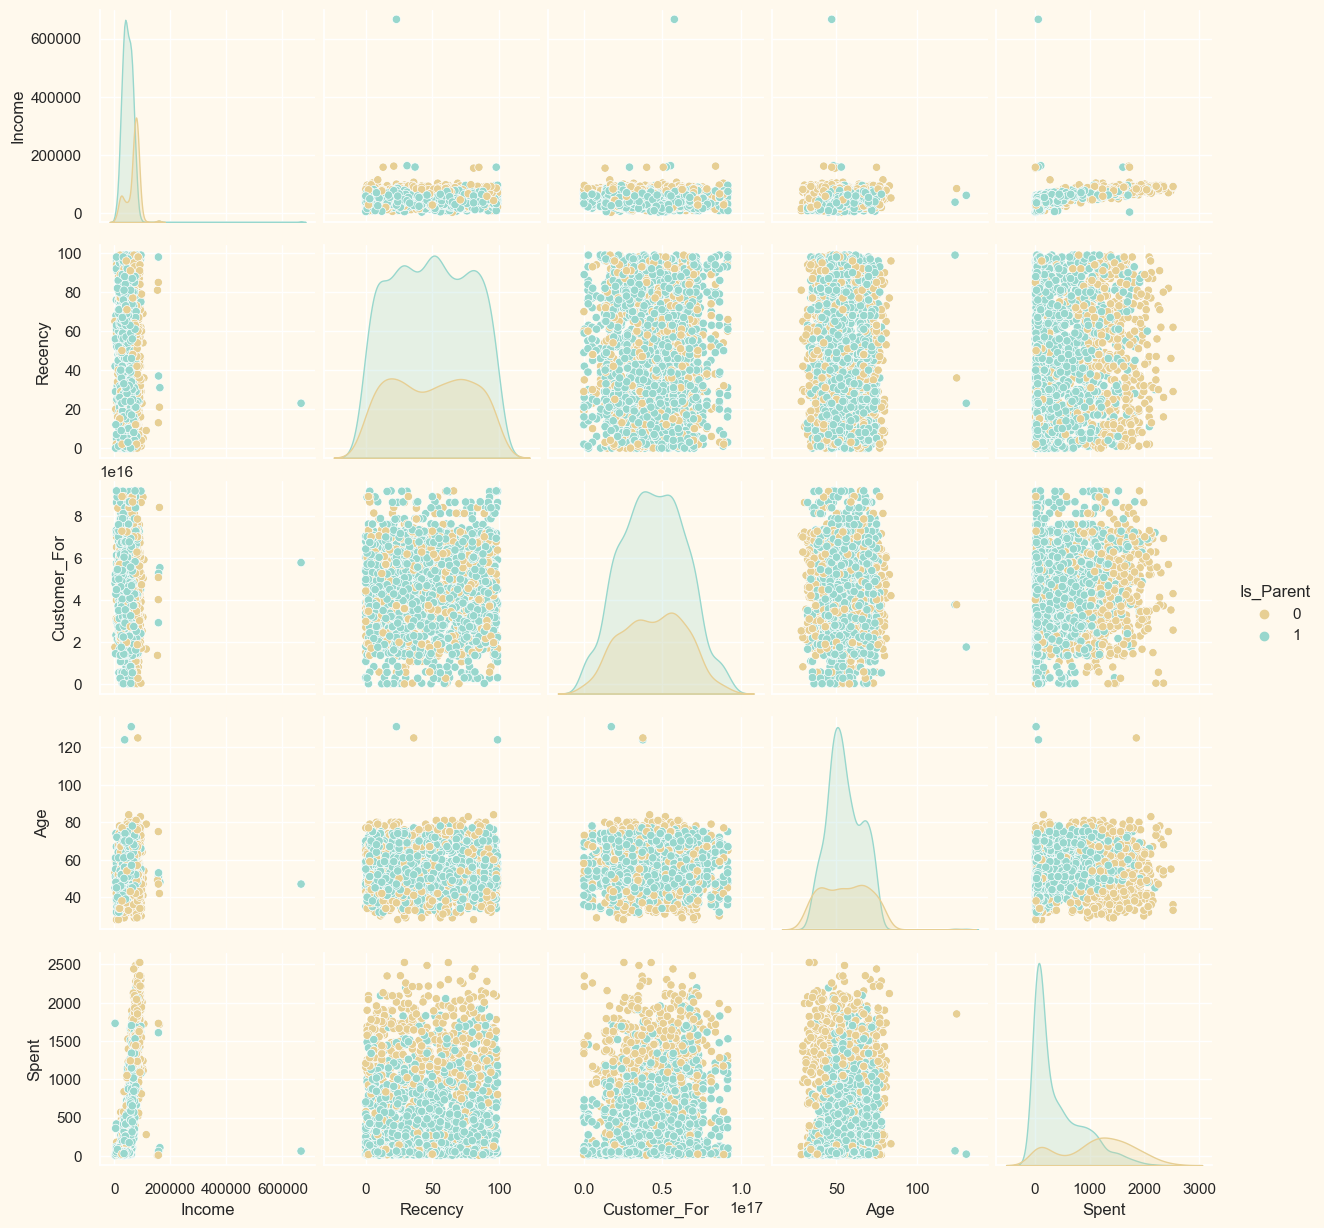

In [228]:
## Let's plot some features
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= 'BrBG')
#Taking hue 
plt.show();

It looks like we have a ouple of extreme outliers in both age and income. Let's try and cut those away and see how that changes our graph.

In [229]:
## Let's drop the outliers in age and income

df = df[(df['Age']<90)]
df = df[(df['Income']<600_000)]
print("Total number of records after removing outliers: ", len(df))

Total number of records after removing outliers:  2212


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

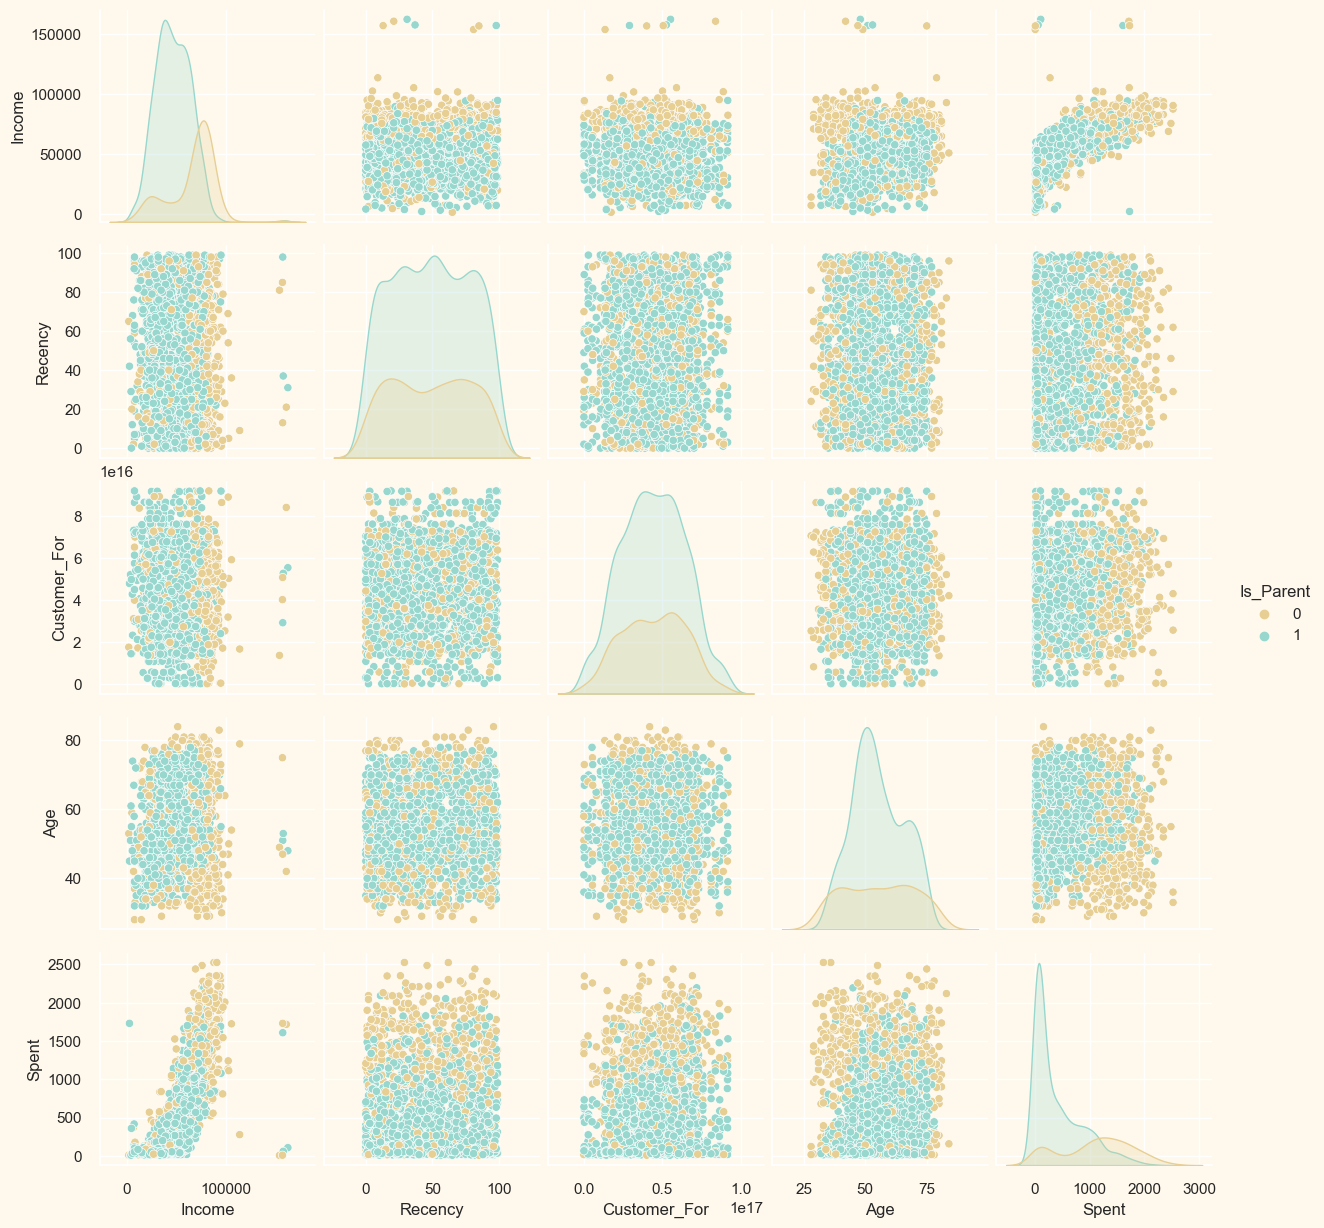

In [230]:
## Let's plot some features
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= 'BrBG')
#Taking hue 
plt.show();

At first blush, looks like being a parent is a clear differentiator. Parents tend to spend more overall, for one thing.

Now let's take a look at the correlation matrix between all our features, and see which are negatively or positively correlated with each other.

<Axes: >

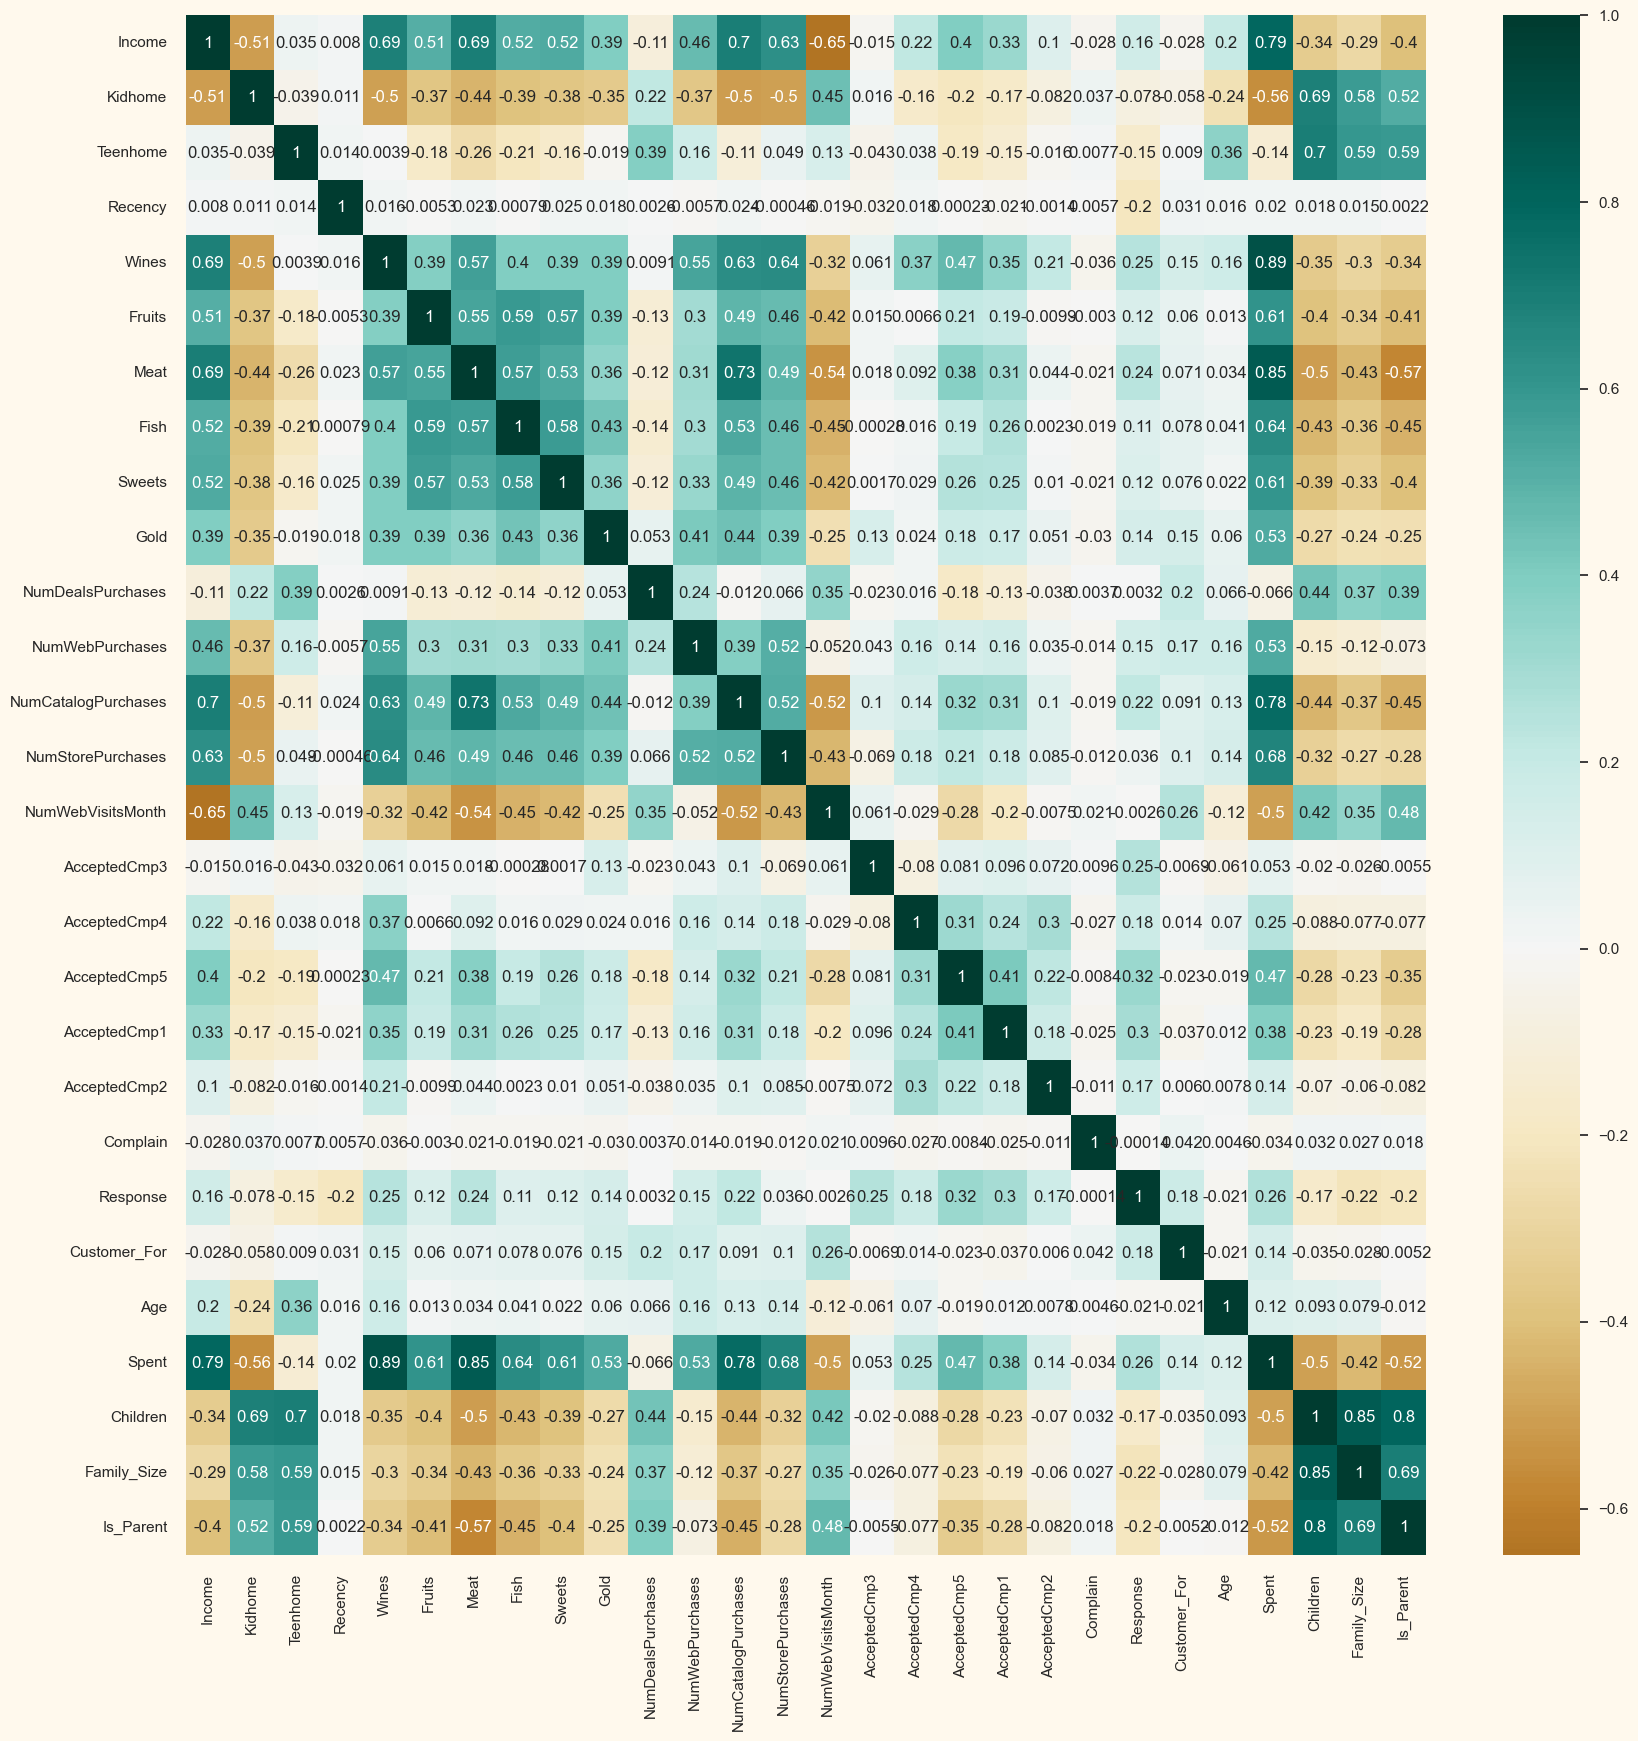

In [232]:
## Let's take a look at the correlation matrix
corrmat = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap='BrBG', center=0)

## Data Preprocessing

In [235]:
## Importing sklearn & yellowbrick packages to set up our scalers, encoders, as well as the PCA and agglomerative
## clustering methods that we'll use to group our customers together

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

from yellowbrick.cluster import KElbowVisualizer

Before we start building our model, we have to make sure it's in the right shape for the job. For one thing, we need to keep track of which of our features are categorical, such that we can put them in numerical format via label encoding. This will allow algorithms that require numerical input to pass this information through correctly.

We will then use a Standard Scaler for all of our numerical features. Variables measured at different scales do not contribute equally to model fitting, and handled blindly would cause bias in our models. Standard Scalers fix this by standardizing numerical features, giving them a mean of 0 and a standard deviation of 1.

Finally, we will create a subset dataframe in order to engage in dimensionality reduction.

In [236]:
## List of Categorical Variables

s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print('Categorical variables in the dataset: ', object_cols)

Categorical variables in the dataset:  ['Education', 'Living_With']


In [237]:
## Label encodigng the object dtypes
LE = LabelEncoder()
for i in object_cols:
    df[i] = df[[i]].apply(LE.fit_transform)
    
print('All features are now numerical')

All features are now numerical


In [238]:
## Copy of the data

ds = df.copy()

# creating a subset of the dataframe by dropping the features on deals accepted and promotions

cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

# Scaling

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns=ds.columns)
print('All features scaled')

All features scaled


In [239]:
# Scaled data to be used for reducing the dimensionality
print('DataFrame to be used for further modeling: ')
scaled_ds.head()

DataFrame to be used for further modeling: 


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1  -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2  -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3  -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4   0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   

       Meat      Fish    Sweets  ...  NumCatalogPurchases  NumStorePurchases  \
0  1.690293  2.453472  1.483713  ...             2.503607          -0.555814   
1 -0.718230 -0.651004 -0.634019  ...            -0.571340          -1.171160   
2 -0.178542  1.339513 -0.147184  ...            -0.229679           1.290224   
3 -0.655787 -0.504911 -0.585335  ...            -0.913000          -0.555814   
4 -0.218684  0.152508 -0.001133  ...             0.111982           0.059532   

   NumWebVisitsMonth  Customer_For       Age     Spent  Living_With  Children  \
0           0.692181      1.973583  1.018352  1.676245    -1.349603 -1.264598   
1          -0.132545     -1.665144  1.274785 -0.963297    -1.349603  1.404572   
2          -0.544908     -0.172664  0.334530  0.280110     0.740959 -1.264598   
3           0.279818     -1.923210 -1.289547 -0.920135     0.740959  0.069987   
4          -0.132545     -0.822130 -1.033114 -0.307562     0.740959  0.069987   

   Family_Size  Is_Parent  
0    -1.758359  -1.581139  
1     0.449070   0.632456  
2    -0.654644  -1.581139  
3     0.449070   0.632456  
4     0.449070   0.632456  

[5 rows x 23 columns]

### Dimensionality Reduction

Now, what do we mean by dimensionality reduction? Well, our dataset has plenty, plenty, plenty of features. Each of these adds a dimension to our dataset. Moreover, we saw through our correlation matrix that many of these features are correlated with each other and are thus redundant. 

We can reduce the number of features (dimensions) in our dataset and minimize the loss of information contained therein by means of Principal Component Analysis, a dimensionality reduction technique that linearly transforms our data to a new coordinate system such that the directions capturing the largest variation in our data can be more easily identified. 

In this case, we will collapse our data to three dimensions.

In [242]:
#Initiating PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(['col1', 'col2', 'col3']))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0  7.709324e-17  2.878377 -5.969395 -2.538494 -0.780421  2.383290   
col2  2212.0  5.139550e-17  1.706839 -4.312179 -1.328295 -0.158024  1.242309   
col3  2212.0  2.810691e-17  1.221955 -3.532868 -0.830283 -0.022496  0.798791   

           max  
col1  7.444305  
col2  6.142654  
col3  6.623964

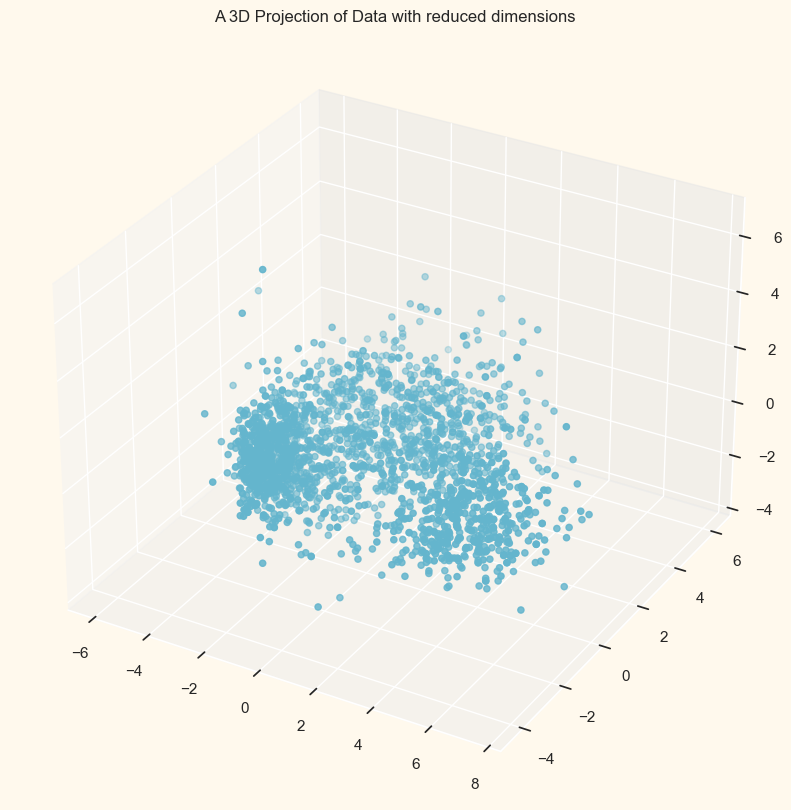

In [243]:
#A 3D Projection of Data with reduced dimensions
x = PCA_ds['col1']
y = PCA_ds['col2']
z = PCA_ds['col3']

#To plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='c', marker='o')
ax.set_title("A 3D Projection of Data with reduced dimensions")
plt.show;

## Clustering

Now that our data has been collapsed into three dimensions, it's time to separate our datapoints into clusters by means of K-Means clustering. Here we make use of the elbow method to find the optimal amount of clusters to separate the data into. The elbow method is a simple heuristic, meant to minimize the distortion score within each cluster while taking account the diminishing returns associated with splitting the dataset into k+1 clusters.

Elbow method to determine the number of clusters we will form:


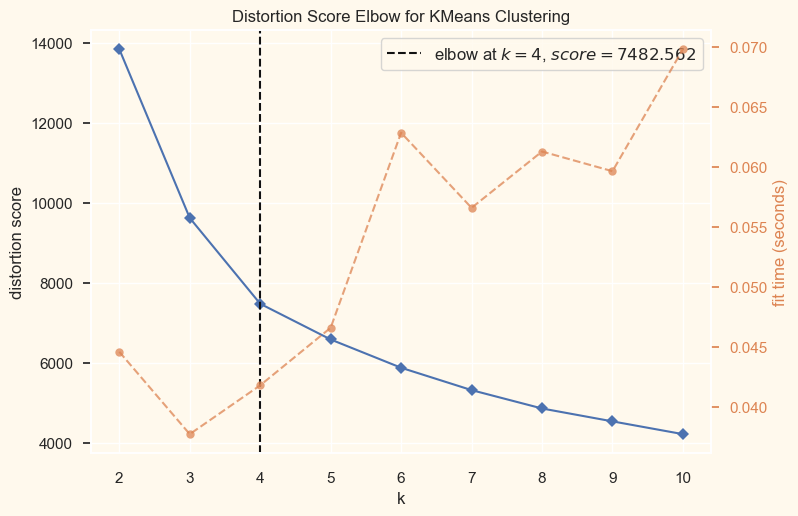

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [245]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow method to determine the number of clusters we will form:')
EM = KElbowVisualizer(KMeans(), k=10)
EM.fit(PCA_ds)
EM.show()

Looks like we're going to go for 4 clusters. Here we will use a clustering method called Agglomerative Clustering. Each data point starts off in its own cluster, and merges with the cluster closest to it within n-dimensional space. This is done until our desired number of clusters (4) is achieved.

In [246]:
# Initiating the Agglomerative Clustering Model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds['Clusters'] = yhat_AC
# Adding the Clusters feature to the original dataframe
df['Clusters'] = yhat_AC

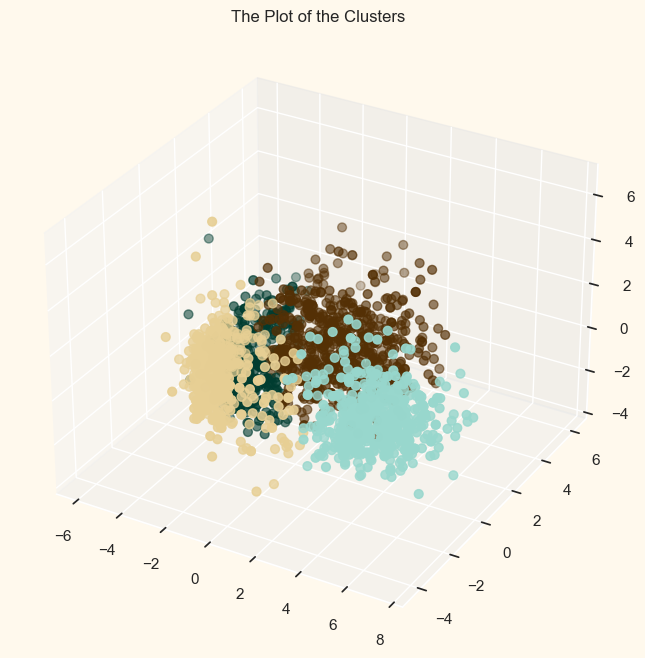

In [247]:
# 3D-Plotting the Clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=PCA_ds['Clusters'], marker='o', cmap='BrBG')
ax.set_title('The Plot of the Clusters')
plt.show()

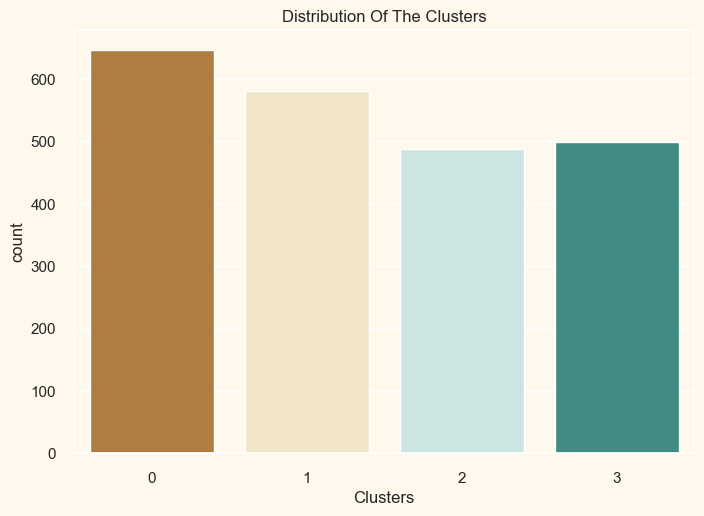

In [248]:
## Plotting countplot of clusters
pl = sns.countplot(x=df["Clusters"], palette= 'BrBG')
pl.set_title("Distribution Of The Clusters")
plt.show()

We see that the dataset is more or less evenly split among clusters, with Cluster0 being marginally the largest of the 4.

Well, what can we say about these clusters? Let's engage in some exploratory data analysis and see if we can spot patterns and differences among the clusters. How do they compare against each other when it comes to income and spending habits? Naturally we'd expect more spending the higher one's income, but can this relationship be split by clusters?

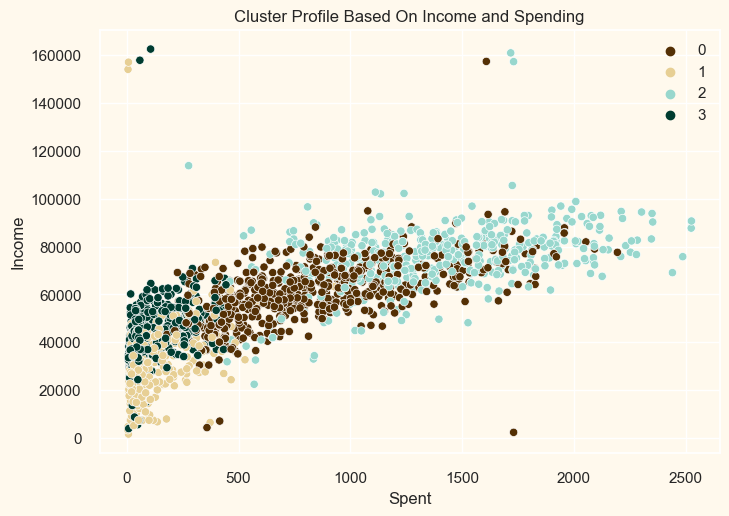

In [249]:
pl = sns.scatterplot(data = df, x=df['Spent'], y=df['Income'], hue=df['Clusters'], palette='BrBG')
pl.set_title('Cluster Profile Based On Income and Spending')
plt.legend()
plt.show()

We do in fact see that a pattern emerges among clusters when we look at the relationship between income and spending:

* Cluster 0: high spending, average income
* Cluster 1: low spending, low income
* Cluster 2: high spending, high income
* Cluster 3: high spending, low income

Let's view this same data in a different form. Let's take a look at how many customers are spending how much for each cluster and see who our top customers are.

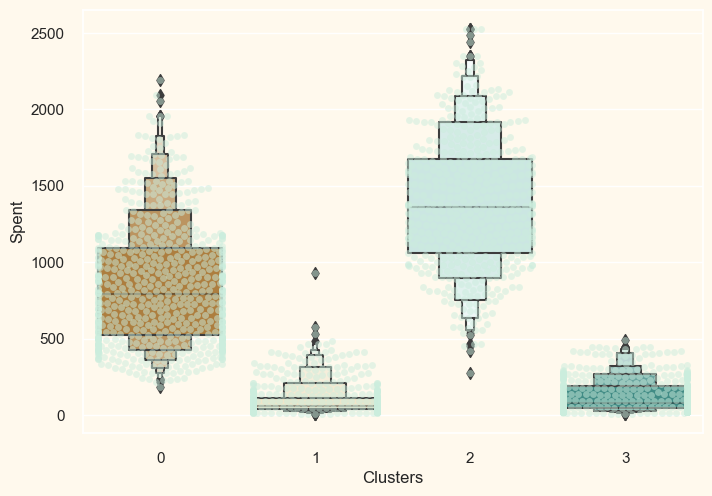

In [250]:
plt.figure()
pl = sns.swarmplot(x=df['Clusters'], y=df['Spent'], color= '#CBEDDD', alpha=0.5)
pl = sns.boxenplot(x=df['Clusters'], y=df['Spent'], palette='BrBG')
plt.show()

Looks like Cluster 2 is the biggest set of customers, followed by Cluster 0.

Next, let's examine how many promotions each group accepted and see if any given cluster is more given to accepting promotions.

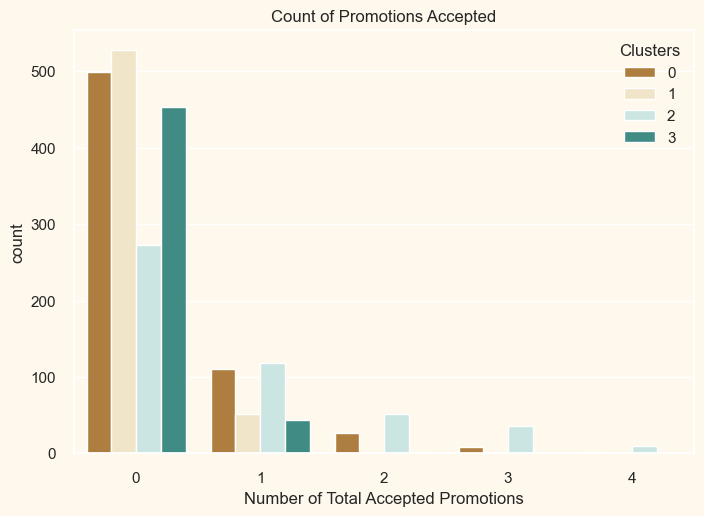

In [252]:
## Examining how campaigns did in the past
## New Feature: A sum of accepted promotions
df['Total_Promos'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
# Plot count of total campaigns accepted
plt.figure()
pl = sns.countplot(x=df['Total_Promos'], hue=df['Clusters'], palette='BrBG')
pl.set_title('Count of Promotions Accepted')
pl.set_xlabel('Number of Total Accepted Promotions')
plt.show()

That's interesting. Looks like promotions aren't generally particularly successful, although Cluster 2 tends to accept the most promotions of the four clusters. Let's try deals next.

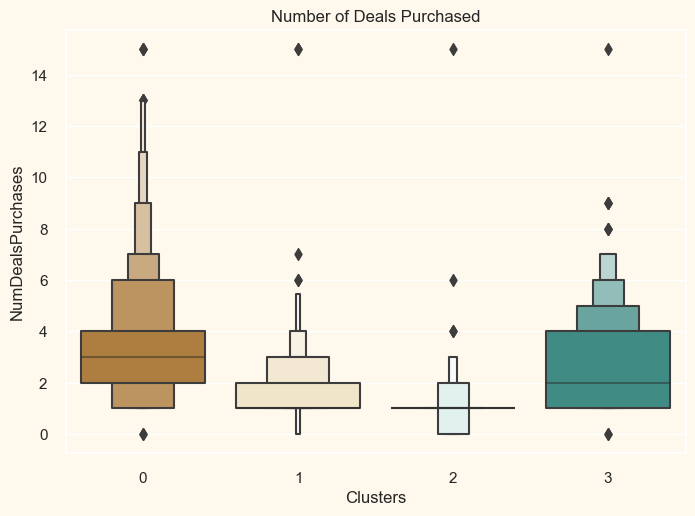

In [253]:
## Plotting number of deals purchased
plt.figure()
pl = sns.boxenplot(y=df['NumDealsPurchases'], x=df['Clusters'], palette='BrBG')
pl.set_title('Number of Deals Purchased')
plt.show()

There's a difference from campaigns here. Deals offered generally did well, especially with Cluster 0 and Cluster 3.

However, Cluster 2 doesn't seem to be into deals, despite being strong customers overall.

## Profiling the Clusters

In this step, we're going to bring back all the features we dropped earlier. We're going to study what characteristics each particular cluster tends to have and thus characterize each cluster comprehensively.

To do this, we'll make use of several plots to demonstrate the distribution of each feature among the four clusters.

<Figure size 800x550 with 0 Axes>

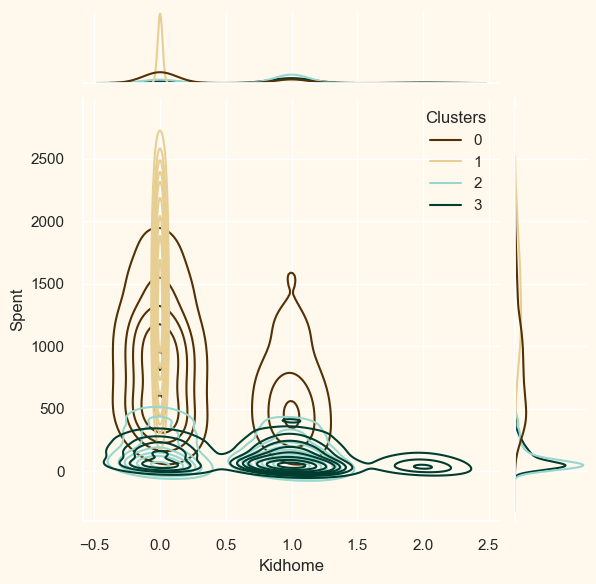

<Figure size 800x550 with 0 Axes>

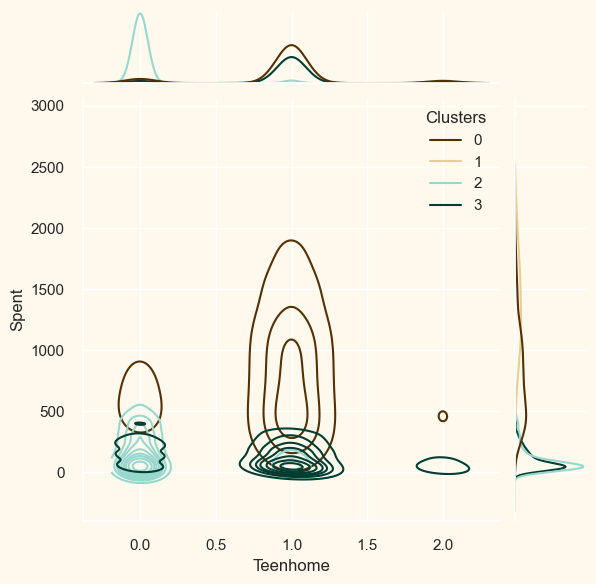

<Figure size 800x550 with 0 Axes>

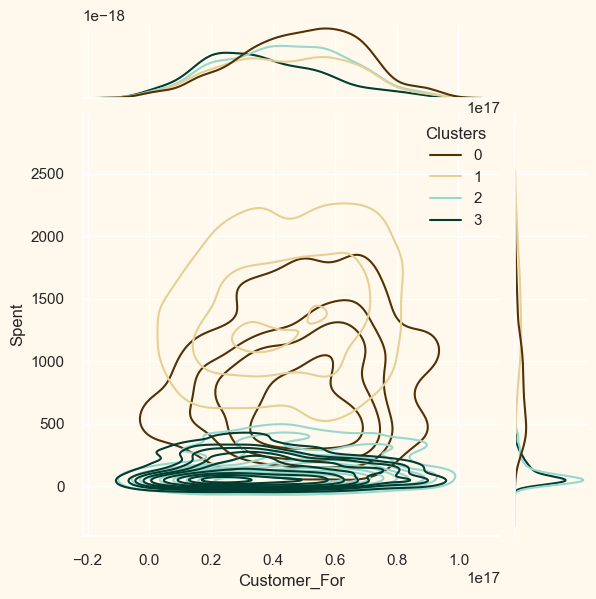

<Figure size 800x550 with 0 Axes>

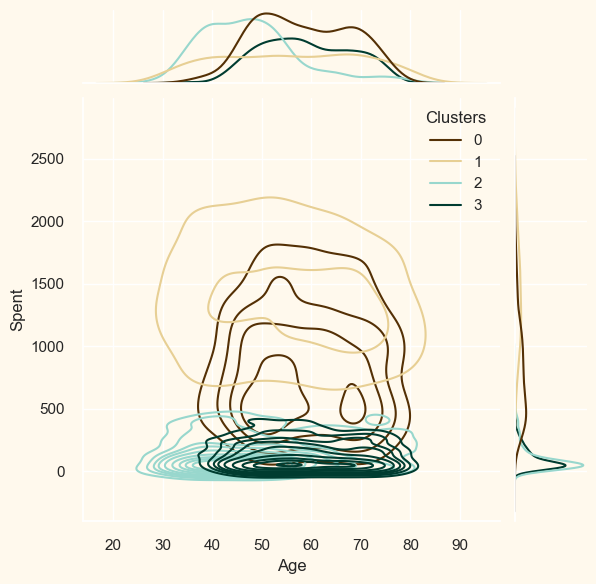

<Figure size 800x550 with 0 Axes>

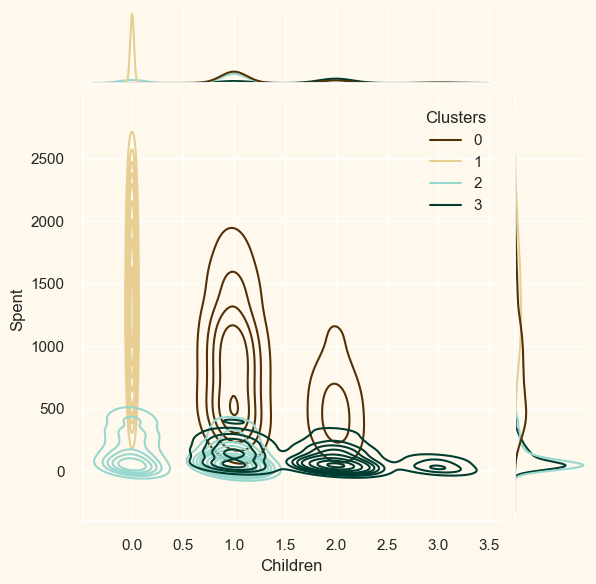

<Figure size 800x550 with 0 Axes>

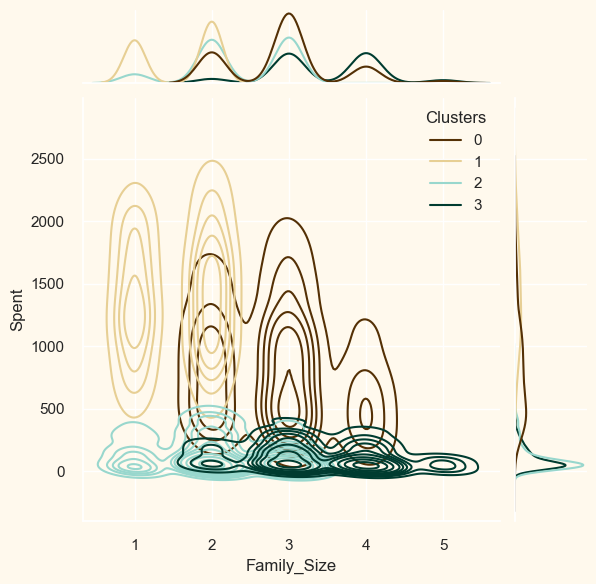

<Figure size 800x550 with 0 Axes>

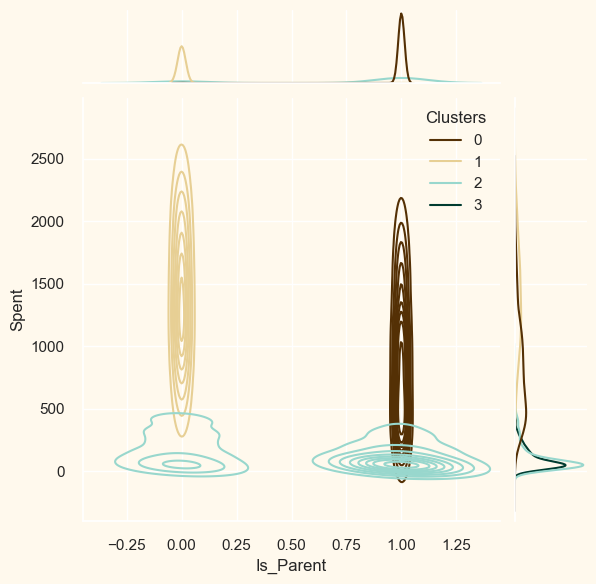

<Figure size 800x550 with 0 Axes>

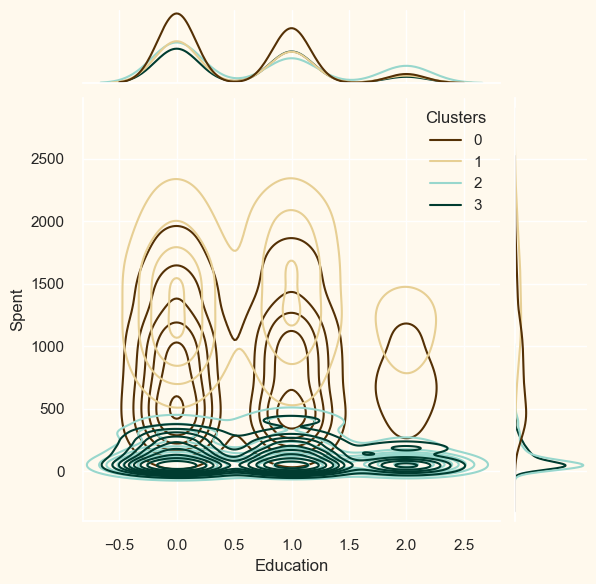

<Figure size 800x550 with 0 Axes>

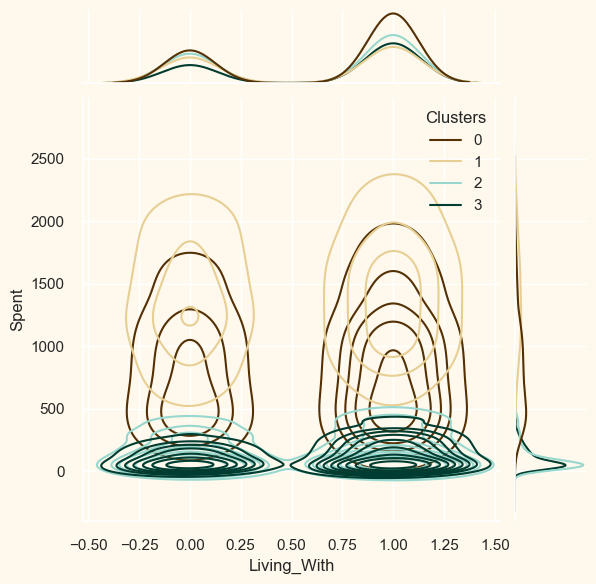

In [170]:
personal = ['Kidhome', 'Teenhome', 'Customer_For', 'Age', 'Children', 'Family_Size', 'Is_Parent', 'Education', 'Living_With']

for i in personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df['Spent'], hue=df['Clusters'], kind='kde', palette='BrBG')
    plt.show();

## Profiling Clusters
### Cluster0: Middle American Families
 The people in this cluster are generally parents (married or single). Their homes have between 2 and 4 family members living in them. Most have teenagers at home. They are relatively older.
 ### Cluster1: Young Parents (Kinda Broke)
The people in this cluster are mostly parents. At most they have 3 people living in their household. The majority have 1 kid (and generally no teenagers around). They tend to skew younger and are a lower-income group.
### Cluster2: The Yuppies and DINKs!
The people in this cluster are generally not parents. At most 2 people live in their household. They're nearly evenly split between couples and single people, though couples are a slight majority. They span all ages and are generally high-income.
### Cluster3: Working American Families
The people in this cluster are almost definitely parents. They have somewhere from 2 to 5 people living in their household. Most have a teenager. They tend to skew relatively older and are a lower-income group.

## Conclusions

Our biggest set of customers are in Cluster 2. Cluster 2 also tends to enjoy promotions. We could give them targeted promotions on premium items such as free-range eggs and perhaps other items with high margins as we expect these customers to not be particularly price-sensitive.

We should likely take into account that Cluster 1 will generally be short on cash and will likely have younger children in the household. Targeted deals on items such as diapers and baby food might increase the propensity of this cluster to spend their hard-earned cash at our store. We should consider giving them steep discounts given these consumers will likely be price-sensitive.